In [1]:
import sys
sys.path.append('..')
from pyurb.urb_kitti import *
import numpy as np
import cv2
%matplotlib inline

Read frame transformations from KITTI sequence 00 into a list of frames (frame).

In [2]:
IMAGE_SIZE = 400

def load(file):
    keyframeids, frameids, poses = load_keyframes(file)
    return keyframeids, frameids, poses.reshape(poses.shape[0], 4, 4)

def load_csv(file):
    poses = np.genfromtxt(file, delimiter= " ")
    poses = np.hstack([poses, np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) ])
    return poses.reshape(poses.shape[0], 4, 4)

def transform(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[:i] = np.dot(points[:i], poses[i].T)
    return points
        
def transform2(poses):
    points = poses[:,:,3]
    return points
    
def plot_trajectory(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1])

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100

    return np.dot(points, t.T)
    

def plot_trajectory2(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1]) * 1.01

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100
    return np.dot(points, t.T)
    
def plot_trajectory3(points):
    coords = []
    minx = min([p[0] for p in points])
    maxx = max([p[0] for p in points])
    miny = min([p[2] for p in points])
    maxy = max([p[2] for p in points])
    maxxy = max(maxx - minx, maxy - miny)* 1.01

    for p in points:
        #print(p)
        x = IMAGE_SIZE * (p[0] - minx) / (maxxy)
        z = IMAGE_SIZE - IMAGE_SIZE * (p[2] - miny) / (maxxy)
        coords.append([x, z])
    return coords

def new_image():
    img = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), np.uint8)
    img[:] = 255 #or img.fill(255)
    return img

def draw(coords, img, color = (0,0,0)):
    # Draw a black line with thickness of 2 px
    for i in range(1,len(coords)):
        cv2.line(img, (int(coords[i - 1][0]), int(coords[i - 1][1])), (int(coords[i][0]), int(coords[i][1])), color, 2)
    return img

Compute the frame positions by mutiplying every point by a sequence of their transformations
vectorized to improve speed

None


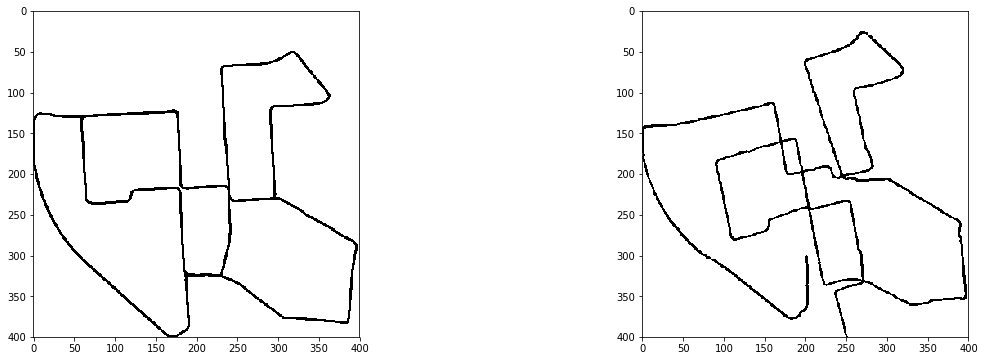

In [3]:
sequence = 0

keyframeids, frameids, poses = load('/data/urbinn/datasets/urb_trajectory_output//keyframes_%02d_all_17_1.6_1.6.npy'%(sequence))
points = transform(poses)
print(frameids)
coords = plot_trajectory3(points)
p = draw(coords, new_image())

gt = load_csv('/data/urbinn/datasets/kitti/poses/%02d.txt'%(sequence))
points_gt = transform2(gt)
coords_gt = plot_trajectory3(points_gt)
show2(draw(coords_gt, new_image()), p)

Show the affine world coodinates for the first 3 poses

In [4]:
v = points[0] - points[-1]
v2 = points_gt[0] - points_gt[-1]
v = v[[0,2, 3]]
v2 = v2[[0,2, 3]]
v, v2

import math
cosalpha  = np.dot(v, v2) / np.linalg.norm(v) / np.linalg.norm(v2)
sinalpha = math.cos(math.pi/2 - math.acos(cosalpha))
print(cosalpha, sinalpha)
points_new = points - points[0]
t = np.eye(4, dtype=np.float64)
t[0,0] = cosalpha
t[2,2] = cosalpha
t[0,2] = sinalpha
t[2,0] = -sinalpha
points_new = np.dot(points_new, t.T)
points_new = points_new + points_gt[0]

0.922477691424 0.3860503967427046


show the converted x,y coordinates to plot the trajectory

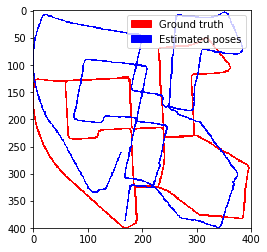

In [5]:
coords = plot_trajectory3(points_new)
p = draw(coords, new_image())
img = draw(coords_gt, new_image(),(255,0,0))
# show(draw(coords, img,(0,0,255)))

show_with_label(draw(coords, img,(0,0,255)), "red", "blue", "Ground truth", "Estimated poses")

In [21]:
import json

yolo_path = "/data/urbinn/darknet/output/batch/0712_260000/objects.json"

try:
    with open(yolo_path) as results:
        results = json.loads(results.read())
        output = json.dumps(results, indent=2, sort_keys=True)
        print(output)
#         print('Checking {} images...'.format(len(results)))       
#         print('Checking {} images...'.format(results))  
except:
    print("Invalid/emp Json file")
    



[
  [
    "007300.png",
    [
      "Lamppost",
      0.6949403285980225,
      [
        139.5919647216797,
        156.5494842529297,
        24.0747013092041,
        330.66705322265625
      ]
    ],
    [
      "Lamppost",
      0.4102920889854431,
      [
        419.0096740722656,
        178.9044647216797,
        12.135031700134277,
        67.07781982421875
      ]
    ]
  ],
  [
    "007301.png"
  ],
  [
    "007302.png",
    [
      "Tram",
      0.8979504704475403,
      [
        569.345703125,
        180.115478515625,
        47.53822326660156,
        37.989864349365234
      ]
    ],
    [
      "Car",
      0.8359929323196411,
      [
        624.9948120117188,
        197.7911834716797,
        36.55804443359375,
        35.348514556884766
      ]
    ],
    [
      "Truck",
      0.6784040927886963,
      [
        474.4647216796875,
        186.60299682617188,
        37.23321533203125,
        29.308223724365234
      ]
    ],
    [
      "Car",
      0.637818813

In [22]:
for i in results:
    print(i.pop(0).replace('.png', ''))
#     match with id to frameid
    for item in i:
        print(item[0])
#         draw item in trajectory
        
        

007300
Lamppost
Lamppost
007301
007302
Tram
Car
Truck
Car
Car
007303
Lamppost
Car
Car
007304
Car
007305
007306
Car
Car
Pole
Car
Lamppost
007307
Traffic_lights
007308
Window
Window
Window
Window
Window
007309
Car
Car
Car
Car
Window
Window
Window
Pedestrian_crossing
Car
Pedestrian_crossing
007310
Window
Window
Window
Window
Window
007311
Window
Car
Car
Car
007312
Car
Car
Commandment_to_pass_sign_on_arrow_indication_D02-RO
007313
Car
Car
Window
Car
Car
Window
007314
Car
Car
Car
Car
Window
Car
007315
Car
Cyclist
Car
007316
Car
Car
Car
Car
007317
Car
Window
007318
Window
Pedestrian
007319
Window
Window
007320
Window
Window
Window
Window
007321
Pedestrian
Commandment_to_pass_sign_on_arrow_indication_D02-RO
007322
Commandment_to_pass_sign_on_arrow_indication_D02-RO
Commandment_to_pass_sign_on_arrow_indication_D02-RO
007323
Car
Car
007324
Car
007325
Car
Car
Car
Car
Car
Car
007326
Guidance_beacon_left
Guidance_beacon_left
007327
Window
Window
Window
Pedestrian
007328
Commandment_to_pass_sign_on

In [23]:
import mpld3
from mpld3 import plugins

# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

fig, ax = plt.subplots()
ax.grid(True, alpha=0.3)

N = 50
df = pd.DataFrame(index=range(N))
df['x'] = np.random.randn(N)
df['y'] = np.random.randn(N)
df['z'] = np.random.randn(N)

labels = []
for i in range(N):
    label = df.loc[[i], :].T
    label.columns = ['Row {0}'.format(i)]
    # .to_html() is unicode; so make leading 'u' go away with str()
    labels.append(str(label.to_html()))

points = ax.plot(df.x, df.y, 'o', color='b',
                 mec='k', ms=15, mew=1, alpha=.6)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('HTML tooltips', size=20)

tooltip = plugins.PointHTMLTooltip(points[0], labels,
                                   voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)

mpld3.display()